In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
df = pd.read_csv('/Users/weimi/Desktop/Online_Retail_II/online_retail_II(2).csv',encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [4]:
df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      417534 non-null  object 
 1   StockCode    417534 non-null  object 
 2   Description  417534 non-null  object 
 3   Quantity     417534 non-null  int64  
 4   InvoiceDate  417534 non-null  object 
 5   Price        417534 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      417534 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 28.7+ MB


In [6]:
df['Amount'] = df['Quantity']*df['Price']
monetary = df.groupby('Customer ID')['Amount'].sum()
monetary = monetary.reset_index()
monetary()

,Customer ID,Amount
0,12346.0,-64.68
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2646.99
4,12351.0,300.93
...,...,...
4378,18283.0,641.77
4379,18284.0,436.68
4380,18285.0,427.00
4381,18286.0,1188.43


In [7]:
df.describe()

,Quantity,Price,Customer ID,Amount
count,417534.000000,417534.000000,417534.000000,417534.000000
mean,12.758815,3.887547,15360.645478,19.994081
std,101.220424,71.131797,1680.811316,99.915863
min,-9360.000000,0.000000,12346.000000,-25111.090000
25%,2.000000,1.250000,13983.000000,4.250000
50%,4.000000,1.950000,15311.000000,11.250000
75%,12.000000,3.750000,16799.000000,19.350000
max,19152.000000,25111.090000,18287.000000,15818.400000


In [8]:
frequency = df.groupby('Customer ID')['Invoice'].count()
frequency = frequency.reset_index()
frequency.head(100)

,Customer ID,Invoice
0,12346.0,46
1,12347.0,71
2,12348.0,20
3,12349.0,107
4,12351.0,21
...,...,...
95,12481.0,177
96,12482.0,207
97,12483.0,67
98,12484.0,134


In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M')

df['Difference'] = max(df['InvoiceDate']) - df['InvoiceDate']
recency = df.groupby('Customer ID')['Difference'].min()

recency = recency.reset_index()
recency.head()

,Customer ID,Difference
0,12346.0,66 days 03:28:00
1,12347.0,2 days 05:04:00
2,12348.0,73 days 05:02:00
3,12349.0,42 days 11:38:00
4,12351.0,10 days 04:38:00


In [10]:
recency['Difference'] = recency['Difference'].dt.days

recency.head()

,Customer ID,Difference
0,12346.0,66
1,12347.0,2
2,12348.0,73
3,12349.0,42
4,12351.0,10


In [11]:
RFM = pd.merge(recency, frequency, on='Customer ID', how='inner')
RFM = pd.merge(RFM, monetary, on='Customer ID', how ='inner')
RFM.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

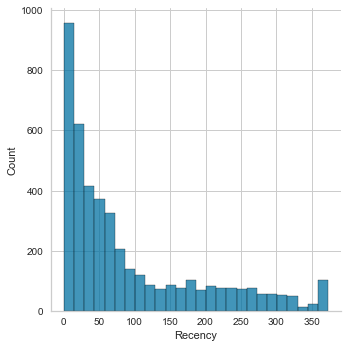

In [12]:
sns.displot(RFM['Recency'])

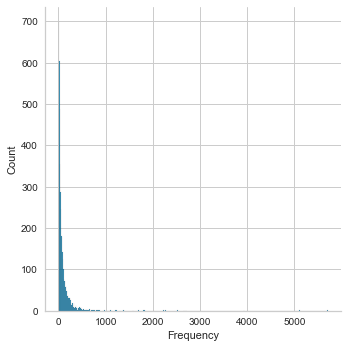

In [13]:
sns.displot(RFM['Frequency'])

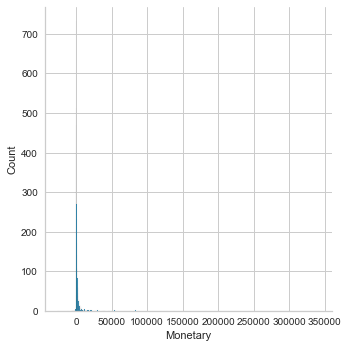

In [14]:
sns.displot(RFM['Monetary'])

In [15]:
mmscaler = MinMaxScaler()
RFM_normalized = RFM[['Monetary','Frequency','Recency']]

In [16]:
RFM_normalized = mmscaler.fit_transform(RFM_normalized)
RFM_normalized = pd.DataFrame(RFM_normalized)
RFM_normalized.columns = ['Monetary', 'Frequency', 'Recency']
RFM_normalized = RFM_normalized[['Monetary','Frequency','Recency']]
RFM_normalized

,Monetary,Frequency,Recency
0,0.068267,0.007882,0.176944
1,0.072050,0.012261,0.005362
2,0.069049,0.003328,0.195710
3,0.075658,0.018567,0.112601
4,0.069264,0.003503,0.026810
...,...,...,...
4378,0.070193,0.040112,0.045576
4379,0.069634,0.004905,0.171582
4380,0.069607,0.001927,0.790885
4381,0.071683,0.012086,0.297587


In [17]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    
    k_means = KMeans(n_clusters = num_clusters, max_iter = 100)
    k_means.fit(RFM_normalized)
    
    cluster_labels = k_means.labels_
    
    sil_avg = silhouette_score(RFM_normalized, cluster_labels)
    print("For n_clusters = {0}, the silhouette score is {1}"
          .format(num_clusters,sil_avg) )

For n_clusters = 2, the silhouette score is 0.7245228597083972
For n_clusters = 3, the silhouette score is 0.6396764647521862
For n_clusters = 4, the silhouette score is 0.5583368460017675
For n_clusters = 5, the silhouette score is 0.5477927378324738
For n_clusters = 6, the silhouette score is 0.5573747814698718
For n_clusters = 7, the silhouette score is 0.5448026985104174
For n_clusters = 8, the silhouette score is 0.5255870220180527
For n_clusters = 9, the silhouette score is 0.4664383993630484
For n_clusters = 10, the silhouette score is 0.46641871216277353


In [18]:
k_means = KMeans(n_clusters = 2, max_iter = 50)
k_means.fit(RFM_normalized)
RFM_normalized.loc[:,'Customer ID'] = RFM['Customer ID']
RFM_normalized['Cluster'] = k_means.labels_

In [19]:
RFM_normalized

,Monetary,Frequency,Recency,Customer ID,Cluster
0,0.068267,0.007882,0.176944,12346.0,1
1,0.072050,0.012261,0.005362,12347.0,1
2,0.069049,0.003328,0.195710,12348.0,1
3,0.075658,0.018567,0.112601,12349.0,1
4,0.069264,0.003503,0.026810,12351.0,1
...,...,...,...,...,...
4378,0.070193,0.040112,0.045576,18283.0,1
4379,0.069634,0.004905,0.171582,18284.0,1
4380,0.069607,0.001927,0.790885,18285.0,0
4381,0.071683,0.012086,0.297587,18286.0,1


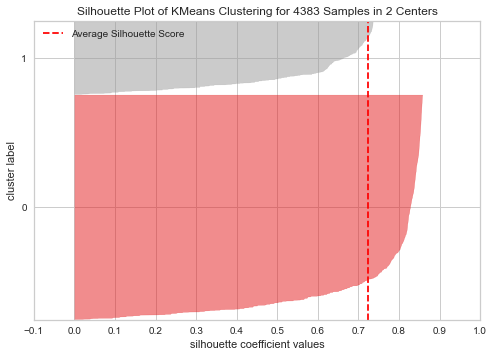

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4383 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
Plot_RFM_normalized = RFM_normalized[['Monetary','Frequency','Recency']].to_numpy()
model = KMeans(n_clusters = 2)
model.fit(Plot_RFM_normalized)
centers = model.cluster_centers_
visualizer = SilhouetteVisualizer(model)

visualizer.fit(Plot_RFM_normalized)   
visualizer.show()

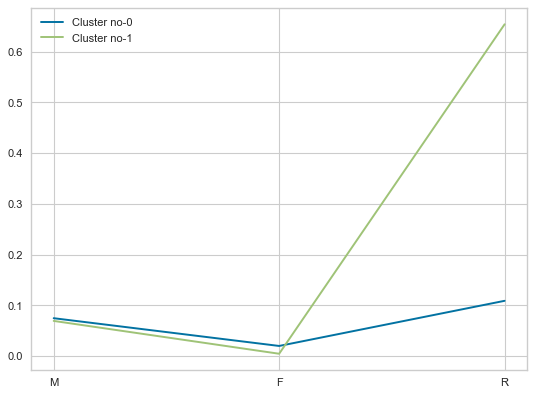

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

# create data
x = ["M","F","R"]
  
# plot lines
for i in range(len(centers)):
  plt.plot(x, centers[i], label = "Cluster no-{}".format(i))
plt.legend()
plt.show()

<AxesSubplot:xlabel='Cluster', ylabel='Monetary'>

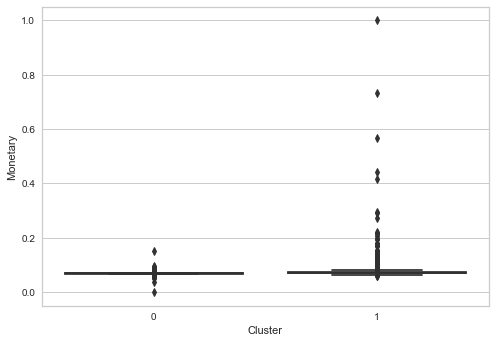

In [22]:
sns.boxplot(x = 'Cluster', y = 'Monetary', data = RFM_normalized)

<AxesSubplot:xlabel='Cluster', ylabel='Frequency'>

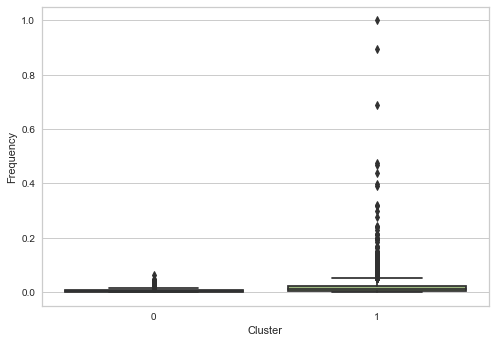

In [23]:
sns.boxplot(x = 'Cluster', y = 'Frequency', data = RFM_normalized)

<AxesSubplot:xlabel='Cluster', ylabel='Recency'>

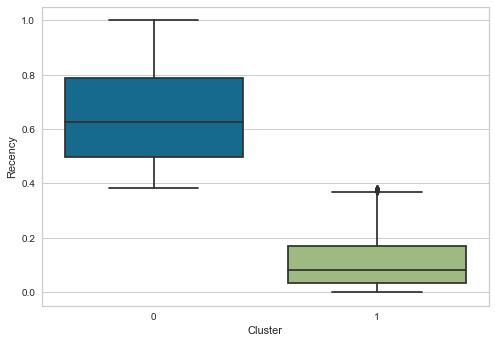

In [24]:
sns.boxplot(x = 'Cluster', y = 'Recency', data = RFM_normalized)

Text(0.5, 1.0, 'Clustering: Monetary vs Recency')

<Figure size 720x720 with 0 Axes>

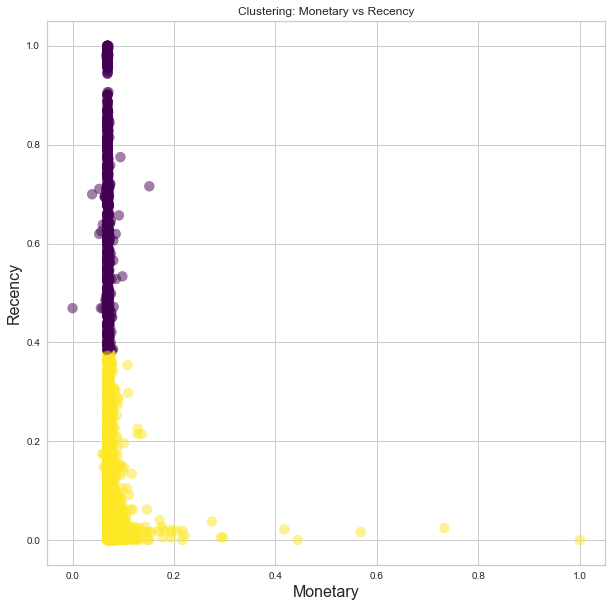

In [25]:
plt.rcParams["figure.figsize"] = (10,10)
fig = plt.figure(1)
plt.clf()
fig, ax = plt.subplots()
ax.scatter(RFM_normalized['Monetary'], RFM_normalized['Recency'], c=RFM_normalized['Cluster'], s=100, alpha=0.5, cmap='viridis')
ax.set_xlabel('Monetary', fontsize=16)
ax.set_ylabel('Recency', fontsize=16)
ax.set_title('Clustering: Monetary vs Recency')

Text(0.5, 1.0, 'Clustering: Monetary vs Frequency')

<Figure size 720x720 with 0 Axes>

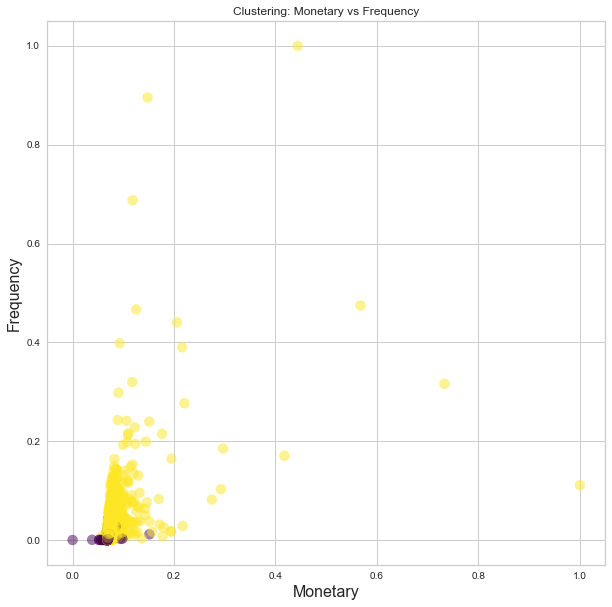

In [26]:
plt.rcParams["figure.figsize"] = (10,10)
fig = plt.figure(1)
plt.clf()
fig, ax = plt.subplots()
ax.scatter(RFM_normalized['Monetary'], RFM_normalized['Frequency'], c=RFM_normalized['Cluster'], s=100, alpha=0.5, cmap='viridis')
ax.set_xlabel('Monetary', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Clustering: Monetary vs Frequency')

Text(0.5, 1.0, 'Clustering: Recency vs Frequency')

<Figure size 720x720 with 0 Axes>

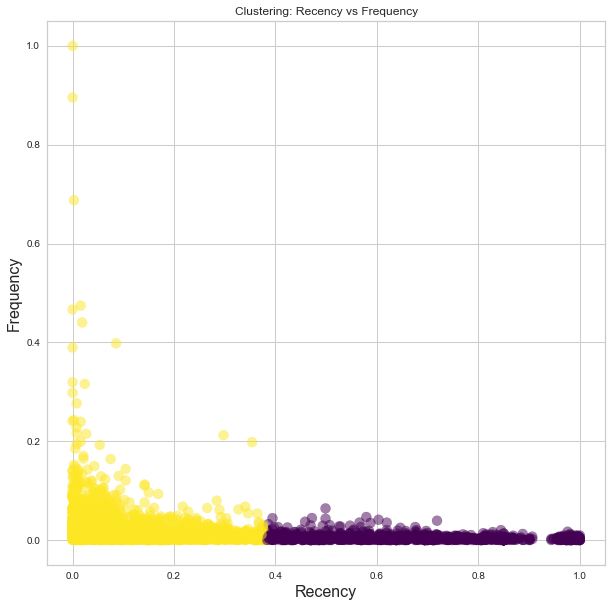

In [27]:
plt.rcParams["figure.figsize"] = (10,10)
fig = plt.figure(1)
plt.clf()
fig, ax = plt.subplots()
ax.scatter(RFM_normalized['Recency'], RFM_normalized['Frequency'], c=RFM_normalized['Cluster'], s=100, alpha=0.5, cmap='viridis')
ax.set_xlabel('Recency', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Clustering: Recency vs Frequency')

Text(0.5, 0, 'Monetary')

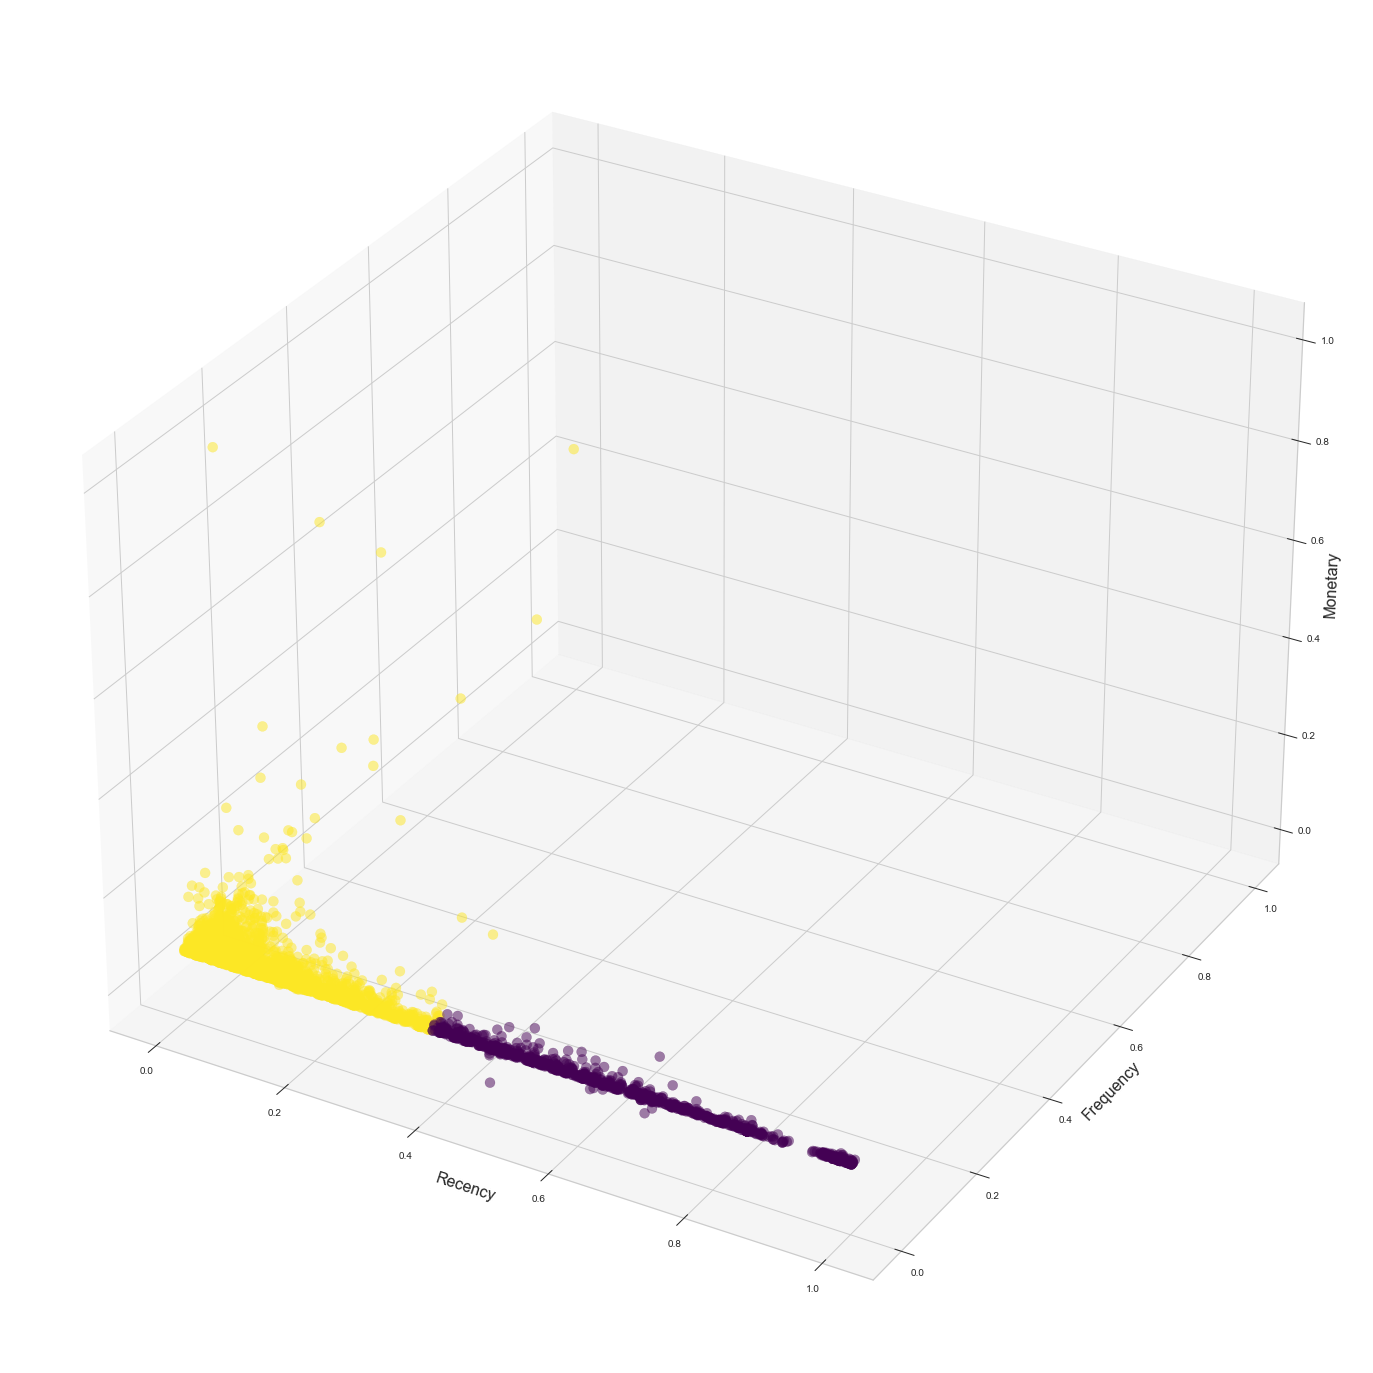

In [28]:
plt.rcParams["figure.figsize"] =(25,25)
fig = plt.figure(1)
plt.clf()
ax = fig.add_subplot(111, projection='3d')

plt.cla()
ax.scatter(RFM_normalized['Recency'], RFM_normalized['Frequency'], RFM_normalized['Monetary'], c=RFM_normalized['Cluster'], s=100, alpha=0.5, cmap='viridis')
ax.set_xlabel('Recency',
             fontsize = 16)
ax.set_ylabel('Frequency',
             fontsize = 16)
ax.set_zlabel('Monetary',
             fontsize = 16)